In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from code.company_data_pipeline import *
from code.ticker_data_pipeline import *
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [14]:
s = get_series_list_from_files(limit=500, min_mean_price_dollars=20)

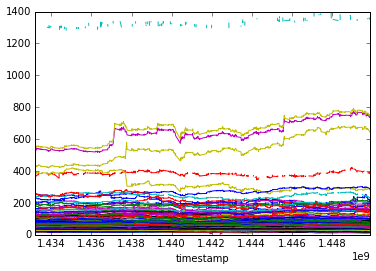

In [15]:
# Data! Horray!
df = pd.DataFrame(data=s).T
df.plot(legend=False)

In [16]:
# Deal with missing values
df = df.interpolate().fillna(method='bfill')

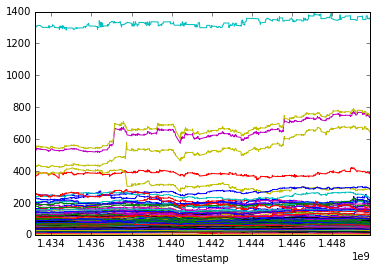

In [17]:
df.plot(legend=False)

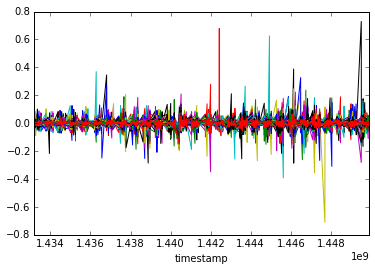

In [18]:
dif_df = df.pct_change().clip(-2, 2).fillna(0.)
dif_df.plot(legend=False)

In [28]:
# X[0] is now NAs because we diffed
X = dif_df.values[1:]
X

array([[ 0.        , -0.00377181, -0.01171495, ..., -0.00832639,
         0.00769349,  0.0030315 ],
       [ 0.        , -0.00118315,  0.009329  , ...,  0.00097957,
        -0.00122156,  0.00989127],
       [ 0.        , -0.00047382,  0.00165352, ...,  0.0090871 ,
         0.00458645, -0.0030899 ],
       ..., 
       [ 0.0064538 , -0.00652681,  0.00043159, ..., -0.0031986 ,
        -0.009811  , -0.0040148 ],
       [ 0.00371245,  0.00164242, -0.00819672, ..., -0.00058343,
        -0.00283477,  0.00403098],
       [ 0.00302623, -0.00562193, -0.00217486, ...,  0.00029189,
         0.00040612, -0.00403633]])

In [20]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, n_components=5, whiten=False)

In [86]:
component = 1

idx = np.argsort(pca.components_[component])[:20]
comp_1_companies = df.columns[idx]
print comp_1_companies
print np.sort(pca.components_[component])[:20]

Index([u'crzo', u'dxpe', u'fstr', u'gtls', u'arii', u'csiq', u'asps', u'cyou',
       u'cmco', u'asei', u'hayn', u'fslr', u'gpre', u'bpop', u'aste', u'hbhc',
       u'apei', u'fang', u'iboc', u'faro'],
      dtype='object')
[-0.09802889 -0.09453683 -0.09399023 -0.09152786 -0.09112558 -0.08407815
 -0.07926437 -0.07600351 -0.07424062 -0.07055423 -0.06955511 -0.06861458
 -0.06841468 -0.06771947 -0.06577409 -0.0647315  -0.06435153 -0.06306293
 -0.06226547 -0.06128052]


In [76]:
with open(PROJECT_HOME + 'data/company/nasdaq_descriptions.tsv') as f:
    company_df = pd.read_csv(f, 
                         sep='\t', 
                         header=None)
company_df.columns = ['ticker', 'description']
company_df = company_df.dropna().set_index('ticker')
company_df.head(10)

,description
ticker,
aaap,We are an innovative radiopharmaceutical compa...
aal,"American Airlines Group Inc. (AAG), a Delaware..."
aame,"Atlantic American Corporation, a Georgia corpo..."
aaoi,This report contains forward-looking statement...
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad..."
aapc,We are a newly organized blank check company i...
aavl,We are a clinical-stage biotechnology company ...
aaww,The following represents terms and statistics ...


In [77]:
tv = TfidfVectorizer(stop_words='english')
tfidf = tv.fit_transform(company_df.description)
company_df['tfidf'] = tfidf.toarray().tolist()
company_df.head()

,description,tfidf
ticker,,
aaap,We are an innovative radiopharmaceutical compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aal,"American Airlines Group Inc. (AAG), a Delaware...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aame,"Atlantic American Corporation, a Georgia corpo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaoi,This report contains forward-looking statement...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [88]:
company_df.ix[comp_1_companies.values, :]['description']

ticker
crzo    Carrizo Oil & Gas, Inc. is a Houston-based ene...
dxpe    DXP was incorporated in Texas in 1996 to be th...
fstr    Formed in 1902, L.B. Foster Company is a Penns...
gtls    Chart Industries, Inc., a Delaware corporation...
arii    American Railcar Industries, Inc. (ARI) is a l...
csiq        Our legal and commercial name is Canadian ...
asps    Altisource® is a premier marketplace and trans...
cyou    Our MMOG business began operations as a busine...
cmco    We are a leading global designer, manufacturer...
asei    American Science and Engineering, Inc., a Mass...
hayn    Haynes International, Inc. ("Haynes" or "the C...
fslr    We are a global provider of solar energy solut...
gpre    References to "we," "us," "our," "Green Plains...
bpop    Popular is a diversified, publicly-owned finan...
aste    Astec Industries, Inc. (the "Company") is a Te...
hbhc    Hancock Holding Company (which we refer to as ...
apei    American Public Education, Inc., or APEI, prov...
fang   

In [81]:
comp_0_companies.values

array(['hznp', 'espr', 'cemp', 'egrx', 'hrtx', 'csiq', 'cybr', 'blue',
       'fprx', 'amba', 'alny', 'atra', 'acad', 'agio', 'clvs', 'anip',
       'icpt', 'cmrx', 'bbc', 'anac'], dtype=object)